## Prepare the text dataset

In [ ]:
import os, pathlib, shutil, random
import keras
import tensorflow as tf

In [ ]:
zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stopwords(sentences):
    results = []
    for s in sentences.numpy():  # .numpy() since inside tf.py_function
        s = s.lower()
        words = s.decode("utf-8").split()
        words2 = [w for w in words if w not in sw]
        results.append(" ".join(words2))
    return results

def remove_stopwords_tf(x, y):
    x_clean = tf.py_function(remove_stopwords, [x], Tout=tf.string)
    return x_clean, y

In [ ]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Moves the test data unaltered
shutil.copytree(imdb_extract_dir / "test", test_dir)

# Splits the training data into a train set and a validation set
val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [ ]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
# apply stopword removal
train_ds = train_ds.map(remove_stopwords_tf, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("first input:", inputs)
    print("first target:", targets[0])
    break

inputs.shape: ()
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
first input: tf.Tensor(b'admittedly, know nothing baseball, even fan sport, stop enjoying farrelly brothers\' latest film, fever pitch, charmingly irreverent romantic comedy. film really baseball; rather, really relationships, emotional disconnectedness often take place.<br /><br />jimmy fallen \xc2\x96 giving best performance date \xc2\x96 stars ben, dorky, lightly nerdy schoolteacher. ben kind man-boy, unfortunately never really grown up, fosters almost fanatical addiction red sox baseball team. ben devoted life sox, everything making pilgrimage florida spring training decorating every square inch apartment team paraphernalia.<br /><br />one day, taking honors geometry class field trip office, ben meets go-getting lindsey (a wonderful drew barrymore). lindsey corporate, career orientated kind girl, kind cuteness ben finds totally endearing. initially hesitant ask out, thinking way "c

## Tokenization & Vectorization

In [ ]:
max_tokens = 20_000

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=200   # pick a max sequence length
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

ValueError: in user code:

    File "/tmp/ipython-input-412156904.py", line 10, in None  *
        lambda x, y: (text_vectorization(x), y)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: as_list() is not defined on an unknown TensorShape.


In [ ]:
idx = 0
for i, word in enumerate(text_vectorization.get_vocabulary()):
    idx += 1
    if idx > 10:
        break
    print(f'{i}: {word}')

0: [UNK]
1: the
2: and
3: a
4: of
5: to
6: is
7: in
8: it
9: i


In [ ]:
for inputs, targets in bag_of_words_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("first input:", inputs[0])
    print("first target:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
first input: tf.Tensor([1 1 1 ... 0 0 0], shape=(20000,), dtype=int64)
first target: tf.Tensor(0, shape=(), dtype=int32)


## Model Design

In [ ]:
hidden_dim = 64

### Pre-trained Embeddings

#### Pre-trained GLoVE

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-10-03 14:36:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-03 14:36:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-03 14:36:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

# choose embedding size
embedding_dim = 50
glove_path = f"glove.6B.{embedding_dim}d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.preprocessing.text import Tokenizer

# Example tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)  # texts = your training corpus
word_index = tokenizer.word_index

num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer_glove = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

#### Pre-trained Embedding Layer

In [ ]:
import tensorflow_hub as hub

embedding_layer_kaggle = hub.load("https://kaggle.com/models/google/gnews-swivel/frameworks/TensorFlow2/variations/tf2-preview-20dim/versions/1")

In [ ]:
import tensorflow as tf

def build_model_kaggle():
    inputs = keras.layers.Input(shape=(None,), dtype=tf.string, name="input")
    x = embedding_layer_kaggle(inputs)
    x = keras.layers.Dense(64, activation="relu", name="dense")(inputs)
    x = keras.layers.Dropout(0.3, name="dropout")(x)
    outputs = keras.layers.Dense(1, activation="sigmoid", name="output")(x)
    model = keras.Model(inputs, outputs)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = build_model_kaggle()
model.summary()

TypeError: Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None, None), dtype=string, sparse=False, ragged=False, name=input>,) and kwargs: {} for signature: (sentences: TensorSpec(shape=(None,), dtype=tf.string, name=None)).

In [ ]:
def build_model(base="cnn", embedding="trainable"):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(max_tokens,), name="input"))
    if embedding == "trainable":
        model.add(keras.layers.Embedding(input_dim=max_tokens,
                                     output_dim=hidden_dim,
                                     name="embedding"))
        adam = 'adam'
    elif embedding == "glove":
        model.add(embedding_layer_glove)
        adam = keras.optimizers.Adam(learning_rate=0.0001)

    if base == "mlp":
        model.add(keras.layers.GlobalAveragePooling1D(name="pooling"))
    elif base == "cnn":
        model.add(keras.layers.Conv1D(64, 3, activation="relu", name="conv"))
        model.add(keras.layers.GlobalAveragePooling1D(name="pooling"))
    elif base == "lstm":
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(hidden_dim)))
    model.add(keras.layers.Dense(64, activation="relu", name="dense"))
    model.add(keras.layers.Dropout(0.3, name="dropout"))
    model.add(keras.layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_model(base='lstm')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 64)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,369 (5.17 MB)

 Trainable params: 1,354,369 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

## Train a model

In [ ]:
model_type = 'mlp'
# model_type = 'cnn'
# embedding = 'trainable'
embedding = 'glove'

In [ ]:
model = build_model(base=model_type, embedding=embedding)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20000, 50)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling                         │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,329 (3.83 MB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
history = model.fit(bag_of_words_train_ds,
                    epochs=10,
                    validation_data=bag_of_words_val_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 192ms/step - accuracy: 0.5038 - loss: 0.7090 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 215ms/step - accuracy: 0.5004 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - accuracy: 0.4923 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.4948 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 224ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 217ms/step - accuracy: 0.4943 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 215ms/step - accuracy: 0.4935 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.4910 -

<Axes: >

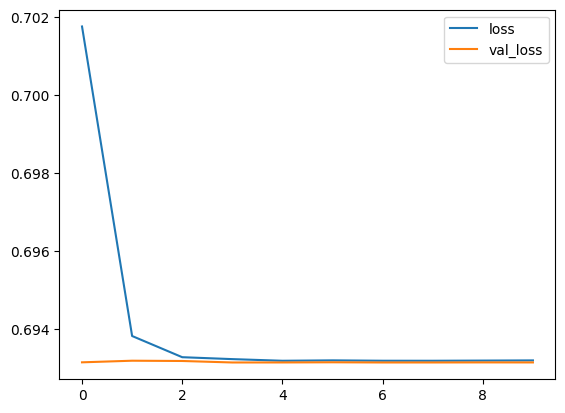

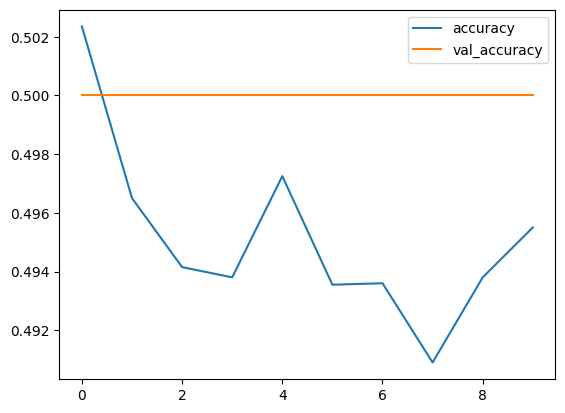

In [ ]:
import pandas as pd
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
print(f"Test accuracy: {test_acc*100:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.4992 - loss: 0.6932
Test accuracy: 50.00
